# NASLib Hands-On



# NASLib overview 🗒
NASLib is a modular and flexible framework created with the aim of providing a common codebase to the community to facilitate research on Neural Architecture Search (NAS). It offers high-level abstractions for designing and reusing search spaces, interfaces to benchmarks and evaluation pipelines, enabling the implementation and extension of several NAS methods with a few lines of code.

![](https://raw.githubusercontent.com/automl/NASLib/Develop_copy/images/naslib-overall.png)

This tutorial will focus on Neural Architecture Search and how NASLib can be leveraged to simplify it greatly.

The tutorial is divided into 4 sections:
1. [Setting up NASLib](#setup)
2. [Search Spaces in NASLib](#search_spaces)
3. [Optimizers in NASLib](#optimizers)
4. [Zero Cost Proxies in NASLib](#zcps)

For each of the tasks in the tutorial, your code should go inside the following block:
```
########## START TODO ############


########## END TODO ##############
```



<a name="setup"></a>
# 1. Setting Up NASLib 💻

We begin by setting up NASLib. First we, clone the repository and install NASLib.

In [ ]:
# Setup NASLib
%cd /content
%rm -rf NASLib
!git clone -b automl-fall-school-2022 https://github.com/automl/NASLib/
%cd /content/NASLib
!pip install -e . --quiet

/content
Cloning into 'NASLib'...
remote: Enumerating objects: 50023, done.
remote: Counting objects: 100% (2111/2111), done.
remote: Compressing objects: 100% (947/947), done.
remote: Total 50023 (delta 1219), reused 1924 (delta 1105), pack-reused 47912
Receiving objects: 100% (50023/50023), 531.68 MiB | 15.10 MiB/s, done.
Resolving deltas: 100% (39788/39788), done.
/content/NASLib
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


You can ignore the pip errors relating to `typing-extensions` and the warning when installing `lightbgm`.

Run the next cell to see if NASLib has been successfully installed.

In [ ]:
import naslib

Next, we download a few datasets and benchmark files that we shall use in this notebook.

In [ ]:
# Download benchmarks
%cd /content/NASLib
!source /content/NASLib/scripts/bash_scripts/download_benchmarks.sh nb201 cifar10
!source /content/NASLib/scripts/bash_scripts/download_benchmarks.sh nb201 cifar100
!source /content/NASLib/scripts/bash_scripts/download_benchmarks.sh nb201 ImageNet16-120
!source /content/NASLib/scripts/bash_scripts/download_benchmarks.sh nb301 cifar10
!source scripts/zc/bash_scripts/download_nbs_zero.sh nb101
!source scripts/zc/bash_scripts/download_nbs_zero.sh nb201
!source scripts/zc/bash_scripts/download_nbs_zero.sh nb301


/content/NASLib
dataset = cifar10
search_space = nb201
Downloading...
From: https://drive.google.com/uc?id=1sh8pEhdrgZ97-VFBVL94rI36gedExVgJ
To: /content/NASLib/naslib/data/nb201_cifar10_full_training.pickle
100% 117M/117M [00:00<00:00, 264MB/s]
dataset = cifar100
search_space = nb201
Downloading...
From: https://drive.google.com/uc?id=1hV6-mCUKInIK1iqZ0jfBkcKaFmftlBtp
To: /content/NASLib/naslib/data/nb201_cifar100_full_training.pickle
100% 117M/117M [00:00<00:00, 246MB/s]
dataset = ImageNet16-120
search_space = nb201
Downloading...
From: https://drive.google.com/uc?id=1FVCn54aQwD6X6NazaIZ_yjhj47mOGdIH
To: /content/NASLib/naslib/data/nb201_ImageNet16_full_training.pickle
100% 117M/117M [00:00<00:00, 236MB/s]
0 1qd9Fkg7MdIe3MMbHtIJC8eZ8OsWcqPYA
Downloading...
From: https://drive.google.com/uc?id=1qd9Fkg7MdIe3MMbHtIJC8eZ8OsWcqPYA
To: /content/NASLib/naslib/data/ImageNet16-120/train_data_batch_1
100% 98.8M/98.8M [00:00<00:00, 246MB/s]
1 train_data_batch_1
Downloading...
From: https://driv

If you were able to download the benchmarks successfully, you can skip to Section 2: Search Spaces in NASLib

If you are unable to download the benchmarks by running the cell above, the alternative solution is to load the data onto your Google Drive, mount your Google drive, and copy the contents to your `/contents/NASLib/naslib/data` folder.

Follow these steps:
1. "Create a shortcut" of [this shared folder](https://drive.google.com/file/d/127uqXUHk1XL4Etqf42x2nrt8lXnhJb56/view?usp=sharing) on Google Drive.
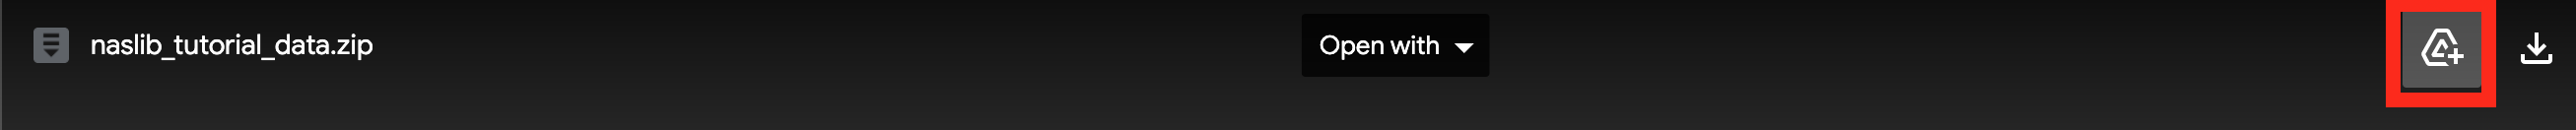
2. Uncomment the next cell and run it to mount your drive
3. Uncomment the cell after the next, fill it with the path to your shortcut (/content/drive/MyDrive/naslib_tutorial_data.zip by default), and run it to unzip the contents to the naslib data folder (/content/NASLib/naslib/data)


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !unzip /content/drive/MyDrive/naslib_tutorial_data.zip -d /content/NASLib/naslib

With that, setup is complete. We can now move on to the next section.

<a name="search_spaces"></a>
# 2. Search Spaces in NASLib 🔍
### What is NAS Search Space?
The search space is the set of all architectures which can be obtained given constraints such as the choice of operations on each edge of the graph and network topologies. We can use knowledge about the typical properties of good architectures for a task to reduce the size of the search space. However, this also introduces a human bias, which may prevent finding
novel architectural building blocks that go beyond the current human knowledge.

Consider the [NAS-Bench-201](https://arxiv.org/pdf/2001.00326.pdf) search space , for example. This search space consists of multiple stacked cells. Each cell is a directed acyclic graph, and the operation on each edge is selected from a predefined set of possible choices.

![](https://drive.google.com/uc?id=1Uw6InTaEWaE2gwgct6ztkLudEz7X3W2y)

### What is a NAS Benchmark?
A NAS benchmark consists of the true or estimated performance of architectures from a NAS Search space, each of which are evaluated on a fixed train-val-test split of the dataset and a fixed training pipeline. There are primarily two types of NAS benchmarks: *surrogate* NAS benchmarks and *tabular* NAS benchmarks.

Surrogate benchmarks use a surrogate model (eg: a neural network) to predict the performance of an architecture from the search space. On the other hand, tabular benchmarks query the actual performance of trained models.

### Why do we need NAS Benchmarks?

1.   Neural Architecture Search often requires large amounts of computational resources. Evaluating a single model requires training it from scratch.
2.   Reproducibility in NAS research: By having a fixed training and evaluation pipeline, NAS Benchmarks minimize confounding factors while comparing different NAS methods.

###NASLib supports multiple search spaces and benchmarks like:

1. [NAS-Bench-101](https://arxiv.org/pdf/1902.09635.pdf)
2. [NAS-Bench-201](https://arxiv.org/pdf/2001.00326.pdf)
3. [NAS-Bench-301](https://arxiv.org/pdf/2008.09777.pdf)
4. [TransNAS-Bench-101](https://arxiv.org/pdf/2105.11871.pdf)

### With a unified API, NASLib allows you to trivially perform several operations, such as:

1. Sampling random models from the search space, which you can use as an actual PyTorch model
2. Querying the Benchmark APIs of models for metrics such as training and validation accuracies
3. Converting between different representations of a given architecture (NASLib, for example, internally represents NAS-Bench-201 architectures using an integer 6-tuple. But you can convert that into the string representation used by the original authors in their repositories)
4. Mutating an architecture

In the next part of the tutorial, we walk through each of these functionalities.



In [ ]:
# Import the search space
# We begin by importing only the NAS-Bench-201 Search Space
from naslib.search_spaces import NasBench201SearchSpace

/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [ ]:
# Create a new search space object.
# This object doesn't have an architecture assigned to it yet - it represents the entire search space
graph = NasBench201SearchSpace(n_classes=10) # CIFAR-10 dataset requires 10 classes

In [ ]:
# Sample a random architecture
# You can call this method only once on any instance
graph.sample_random_architecture()

# Parse the sampled architecture into a PyTorch model - this model can now be trained like a regular PyTorch model
# (This step is optional because we're not training the model from scratch)
graph.parse()

# Get the NASLib representation of the sampled model
graph.get_hash()

(4, 2, 3, 4, 1, 3)

In [ ]:
# This graph is now a NAS-Bench-201 model, which can be trained
# Forward pass some dummy data through it to see it in action

import torch

x = torch.randn(5, 3, 32, 32) # (Batch_size, Num_channels, Height, Width)

logits = graph(x)

print('Shape of the logits:', logits.shape)

Shape of the logits: torch.Size([5, 10])


In [ ]:
# Import code to convert NASLib graph to the original NAS-Bench-201 representation
from naslib.search_spaces.nasbench201.conversions import convert_naslib_to_str as convert_naslib_nb201_to_str

# Get the string representation of this model, that the original authors of NAS-Bench-201 used
convert_naslib_nb201_to_str(graph)

'|avg_pool_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|nor_conv_1x1~0|none~1|nor_conv_1x1~2|'

In [ ]:
# Mutating an architecture
# First, create a new child_graph
child_graph = NasBench201SearchSpace(n_classes=10)

# Call mutate on the child graph by passing the parent graph to it
child_graph.mutate(parent=graph)

# See the parent and child graph representations. Which edge was mutated?
print(f'Parent graph: {graph.get_hash()}')
print(f'Child graph : {child_graph.get_hash()}')

Parent graph: (4, 2, 3, 4, 1, 3)
Child graph : (4, 2, 3, 4, 2, 3)


In [ ]:
# Now, let's load the queryable tabular NAS-Bench-201 API
# This API has the training metrics of all the 15625 models in the search space
# such as train and validation accuracies/losses at every epoch
from naslib.utils import get_dataset_api
benchmark_api = get_dataset_api(search_space='nasbench201', dataset='cifar10')

In [ ]:
# We now import all the benchmarks that we will require for this exercise
# Load all benchmarks APIs just once to avoid running out of memory
dataset_apis={}
# dataset_apis["NASBench101-cifar10"] = get_dataset_api(search_space='nasbench101', dataset='cifar10')
dataset_apis["NASBench201-cifar10"] = get_dataset_api(search_space='nasbench201', dataset='cifar10')
dataset_apis["NASBench201-cifar100"] = get_dataset_api(search_space='nasbench201', dataset='cifar100')
dataset_apis["NASBench201-ImageNet16-120"] = get_dataset_api(search_space='nasbench201', dataset='ImageNet16-120')
dataset_apis["NASBench301-cifar10"] = get_dataset_api(search_space='nasbench301', dataset='cifar10')

1.85GiB [00:35, 52.3MiB/s]


Extracting models_1.0.zip to /content/NASLib/naslib/data/nb_models_1.0
Deleting downloaded zip at /content/NASLib/naslib/data/models_1.0.zip


In [ ]:
# With the NAS-Bench-201 API, we can now query, say, the validation performance of any NB201 model
# Without it, we would have to train the model from scratch to get this information

# First, import the Metric enum
from naslib.search_spaces.core import Metric

# Metric has, among others, these values:
# Metric.TRAIN_ACCURACY
# Metric.VAL_ACCURACY
# Metric.TRAIN_LOSS
# Metric.TEST_LOSS
# Metric.TRAIN_TIME

train_acc_parent = graph.query(metric=Metric.TRAIN_ACCURACY, dataset='cifar10', dataset_api=dataset_apis["NASBench201-cifar10"])
val_acc_parent = graph.query(metric=Metric.VAL_ACCURACY, dataset='cifar10', dataset_api=dataset_apis["NASBench201-cifar10"])

print('Performance of parent model')
print(f'Train accuracy: {train_acc_parent:.2f}%')
print(f'Validation accuracy: {val_acc_parent:.2f}%')

Performance of parent model
Train accuracy: 99.91%
Validation accuracy: 88.80%


ImportError: ignored

#Task 1: NAS-Bench-301 (10 minutes)

Now that you are familiar with the operations search spaces in NASLib, we can attempt our first task. In this task, you should do the following:

1. Sample a random NAS-Bench-301 model
2. Get the NASLib representation of the model
3. Query the performance of the model
4. Mutate the model
5. Query the performance of the mutated model

All the modules you require are already imported for you.

In [ ]:
from naslib.search_spaces import NasBench301SearchSpace

########## START TODO ############

# 1. Sample a random NAS-Bench-301 (CIFAR-10) model
# 2. Get the NASLib representation of the model
# 3. Query the performance of the model
# 4. Mutate the model
# 5. Query the performance of the mutated model
# Metrics you can query in NAS-Bench-301 (which is a surrogate benchmark) are Metric.VAL_ACCURACY and Metric.TRAIN_TIME

graph301 = NasBench301SearchSpace(n_classes=10)
graph301.sample_random_architecture()

# Write your code here

########## END TODO ##############

In [ ]:
# 2. Get the NASLib representation of the model

graph301.parse()

# Get the NASLib representation of the sampled model
graph301.get_hash()

(((1, 2), (0, 1), (0, 2), (2, 0), (2, 2), (3, 1), (4, 3), (0, 2)),
 ((0, 3), (1, 4), (0, 6), (2, 1), (1, 4), (3, 6), (0, 5), (4, 5)))

In [ ]:

# 3. Query the performance of the model


train_acc_parent_301 = graph301.query(metric=Metric.TRAIN_ACCURACY, dataset='cifar10', dataset_api=dataset_apis["NASBench301-cifar10"])
val_acc_parent_301 = graph301.query(metric=Metric.VAL_ACCURACY, dataset='cifar10', dataset_api=dataset_apis["NASBench301-cifar10"])

print('Performance of 301 model')
print(f'Train accuracy: {train_acc_parent_301:.2f}%')
print(f'Validation accuracy: {val_acc_parent_301:.2f}%')

Performance of 301 model
Train accuracy: -1.00%
Validation accuracy: 92.75%


In [ ]:
# First, create a new child_graph
child_graph_301 = NasBench301SearchSpace(n_classes=10)

# Call mutate on the child graph by passing the parent graph to it
child_graph_301.mutate(parent=graph301)

In [ ]:

train_acc_child_301 = child_graph_301.query(metric=Metric.TRAIN_ACCURACY, dataset='cifar10', dataset_api=dataset_apis["NASBench301-cifar10"])
val_acc_child_301 = child_graph_301.query(metric=Metric.VAL_ACCURACY, dataset='cifar10', dataset_api=dataset_apis["NASBench301-cifar10"])

print('Performance of 301 child model')
print(f'Train accuracy: {train_acc_child_301:.2f}%')
print(f'Validation accuracy: {val_acc_child_301:.2f}%')


Performance of 301 child model
Train accuracy: -1.00%
Validation accuracy: 92.95%


<a name="optimizers"></a>
# 3. NAS Optimizers 📈

## What is a NAS Optimizer?
The NAS Optimizer is a search strategy used to explore the search space to find a well-performing architecture.


![](https://drive.google.com/uc?id=1e7a4LI-f7embNqUq23FwlysP6mQu63nx)

Given the different NAS benchmarks, we now want to search for the optimal architectures from the search spaces. NASLib provides a uniform API to use multiple optimizers across different benchmarks. One could easily write their own optimizer and evaluate it across the different NAS benchmarks.

## What is a performance predictor?
Performance Estimation in NAS refers to getting an approximation of the performance of a given architecture. One trivial example of this is training a candidate architecture to convergence, but this can get very expensive. Much recent research therefore focuses on developing methods that reduce the cost of these performance estimations. A [performance predictor](https://arxiv.org/pdf/2104.01177.pdf) is generally defined as any function  (eg: xgboost) which predicts the final accuracy or ranking of architectures, without fully training the architectures.

Some of the optimizers supported in NASLib are:


1.   [Random search](https://arxiv.org/pdf/1902.07638.pdf)
2.   [Local Search](https://arxiv.org/pdf/2004.08996.pdf)
3.   [Regularized Evolution](https://arxiv.org/pdf/1802.01548.pdf)
4.   [BANANAS](https://arxiv.org/pdf/1910.11858.pdf)

In this section of the tutorial, we will walk through the following:


1. Searching for optimal models using [Random search (RS)](https://arxiv.org/pdf/1902.07638.pdf) on different NAS benchmarks.
2. Searching for optimal models using [Regularized Evolution (RE)](https://arxiv.org/pdf/1802.01548.pdf) and comparing it with RS
3. Searching for optimal models using [BANANAS](https://arxiv.org/pdf/1910.11858.pdf) and comparing with RE and RS.

In [ ]:
# The functions below setup and run the search experiments
import naslib.utils as utils

def update_config(config, optimizer_type, search_space_type, dataset, seed):
    # Dataset being used
    config.dataset = dataset

    # Directory to which the results/logs will be saved
    config.save = f"runs/{optimizer_type.__name__}/{search_space_type.__name__}/{dataset}/{seed}"

    # Seed used during search phase of the optimizer
    config.search.seed = seed

def run_optimizer(optimizer_type, search_space_type, dataset, dataset_api, config, seed):
    # Update the config
    update_config(config, optimizer_type, search_space_type, dataset, seed)

    # Make the results directories
    os.makedirs(config.save + '/search', exist_ok=True)
    os.makedirs(config.save + '/eval', exist_ok=True)

    # Set up the loggers
    logger = setup_logger()
    logger.setLevel(logging.INFO)

     # See the config
    logger.info(f'Configuration is \n{config}')

    # Set up the seed
    utils.set_seed(seed)
    # Instantiate the search space
    n_classes = {
        'cifar10': 10,
        'cifar100': 100,
        'ImageNet16-120': 120
    }
    search_space = search_space_type(n_classes=n_classes[dataset])
    search_space.instantiate_model = False
    # Get the benchmark API
    logger.info('Loading Benchmark API')

    # Instantiate the optimizer and adapat the search space to the optimizer
    optimizer = optimizer_type(config)
    optimizer.adapt_search_space(search_space, dataset_api=dataset_api)

    # Create a Trainer
    trainer = Trainer(optimizer, config)

    # Perform the search
    trainer.search(report_incumbent=False)

    # Get the results of the search
    search_trajectory = trainer.search_trajectory
    print('Train accuracies:', search_trajectory.train_acc)
    print('Validation accuracies:', search_trajectory.valid_acc)
    # Get the validation performance of the best model found in the search phase
    best_model_val_acc = trainer.evaluate(dataset_api=dataset_api, metric=Metric.VAL_ACCURACY)

    best_model = optimizer.get_final_architecture()

    return search_trajectory, best_model, best_model_val_acc

In [ ]:
# Functions used for plotting the results of using different optimizers

%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import FormatStrFormatter
from naslib.utils.logging import setup_logger

# plot performance vs runtime

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = 'dotted'
# set up colors and plot markings
defaults = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
            (1.0, 0.4980392156862745, 0.054901960784313725),
            (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
            (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
            (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
            (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
            (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
            (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
            (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
            (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

c_max = 9
colors = [*defaults[:c_max], *defaults[:c_max], *defaults[:c_max]]
fmts = [*['-'] * c_max, *['--'] * c_max, *[':'] * c_max]
markers = [*['^'] * c_max, *['v'] * c_max, *['o'] * c_max]


def get_results(results, metric='valid_acc', dataset='cifar10', ug=False):
    output = []
    time = []
    for result in results:
        val_acc = result['valid_acc']
        surr_time = np.array(result['runtime'])
        if ug:
            runtime = 200 * np.array(result['train_time']) + surr_time
        else:
            runtime = np.array(result['train_time']) + surr_time
        val_err = [100 - x for x in val_acc]
        val_incumbent = [
            min(val_err[:epoch]) for epoch in range(1,
                                                    len(val_err) + 1)
        ]
        runtime = [
            sum(runtime[:epoch]) for epoch in range(1,
                                                    len(runtime) + 1)
        ]
        if metric == 'valid_acc':
            incumbent = val_incumbent
        elif metric == 'test_acc':
            test_err = [100 - x for x in result['test_acc']]
            inc_idx, best, best_idx = [], np.inf, 0
            for i, err in enumerate(val_err):
                if err < best:
                    best, best_idx = err, i
                    inc_idx.append(best_idx)
                    incumbent = [test_err[idx] for idx in inc_idx]
        output.append(incumbent)
        time.append(runtime)
    output = np.array(output)
    time = np.array(runtime)
    mean = np.mean(output, axis=0)
    std = np.std(output, axis=0)
    std_error = np.sqrt(
        np.var(output, axis=0, ddof=1) / np.asarray(output).shape[0])
    return mean, std, std_error, time


def plot_optimizers(trajectories, benchmark_title):
    plot_zoomed = False
    plot_sem = True
    fig, ax = plt.subplots(figsize=[10, 5])
    if plot_zoomed:
        sub_axes = plt.axes([.6, .6, .25, .25])
    i = 0
    for optimizer in trajectories.keys():
        mean, std, std_error, time = get_results(trajectories[optimizer])
        results_dict = {}
        results_dict = {
            'label': optimizer,
            'mean': mean,
            'runtime': time,
            'std_error': std_error
        }
        mean = results_dict['mean']
        x = results_dict['runtime']
        sem = results_dict['std_error']
        label = results_dict["label"]
        ax.plot(x, mean, label=label, color=colors[i], linestyle=fmts[i])
        ax.fill_between(x,
                        mean - 1 * sem,
                        mean + 1 * sem,
                        color=colors[i],
                        alpha=0.2)
        i = i + 1
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.set_xscale('log')
    ax.legend(loc=(1.04, 0))
    ax.set_xlabel('Runtime [s] (simulated)')
    ax.set_ylabel('Test error (%)')
    ax.grid(True, which="both", ls="-", alpha=.5)
    ax.set_title('Test error vs. train time on '+benchmark_title)

## Random Search
Random search samples an architecture in every epoch and computes its validation error. When benchmarks are present, this computation is merely a look-up of the tabular benchmark, or a query of the surrogate benchmark. When benchmarks are not present, this means training the model from scratch and evaluating it.

In [ ]:
# imports we will use throughout this section
import json
import logging
import os

# import the Trainer used to run the optimizer on a given search space
from naslib.defaults.trainer import Trainer

# import the NAS-Bench-201 search space
from naslib.search_spaces import NasBench201SearchSpace

# import the optimizers: Random Search, Regularized Evolution, and Bananas
from naslib.optimizers import (
    RandomSearch,
    RegularizedEvolution,
    Bananas
)

# Import Metric required to query the NAS Benchmarks
from naslib.search_spaces.core.query_metrics import Metric

# Import CfgNode required to create the config
from fvcore.common.config import CfgNode

In [ ]:
# Initialize trajectories
# This variable will be used to store the results of all experiments, which we shall then plot.
trajectories = {}

In [ ]:
# Set the optimizer and search space types
# They will be instantiated inside run_optimizer
optimizer_type = RandomSearch # {RegularizedEvolution, RandomSearch}
search_space_type = NasBench201SearchSpace # {NasBench101SearchSpace, NasBench201SearchSpace, NasBench301SearchSpace}

# Set the dataset
dataset = 'cifar10' # cifar10 for NB301, {cifar10, cifar100, ImageNet16-120} for NB201, cifar10 for NB101

# The configuration used by the Trainer and Optimizer
# The missing information will be populated inside run_optimizer
config_dict = {
    'search': {
        # Required by Trainer
        'epochs': 100, # Number of steps of the optimizer to run (in case of Random Search, for example, this is the number of models sampled)
        'checkpoint_freq': 200,

        # Required by Random Search optimizer
        'fidelity': -1,

        # Required by RegularizedEvolution
        'sample_size': 10,
        'population_size': 30,
    }
}
config = CfgNode(config_dict)

# Initialize trajectories for the 3 seeds
trajectories["RS"] = []

for seed in [333, 444, 555]: # Run RS for 3 seeds
    search_trajectory, best_model, best_model_val_acc = run_optimizer(
                                                          optimizer_type,
                                                          search_space_type,
                                                          dataset,
                                                          dataset_apis["NASBench201-cifar10"],
                                                          config,
                                                          seed
                                                      )
    trajectories["RS"].append(search_trajectory)

[10/11 14:55:33 naslib]: Configuration is 
dataset: cifar10
save: runs/RandomSearch/NasBench201SearchSpace/cifar10/333
search:
  checkpoint_freq: 200
  epochs: 100
  fidelity: -1
  population_size: 30
  sample_size: 10
  seed: 333
[10/11 14:55:35 naslib]: Loading Benchmark API
[10/11 14:55:35 nl.defaults.trainer]: Beginning search
[10/11 14:55:35 nl.defaults.trainer]: Epoch 0 done. Train accuracy: 99.54800, Validation accuracy: 83.83000
[10/11 14:55:36 nl.defaults.trainer]: Epoch 1 done. Train accuracy: 72.61200, Validation accuracy: 66.22000
[10/11 14:55:36 nl.defaults.trainer]: Epoch 2 done. Train accuracy: 99.91200, Validation accuracy: 88.09000
[10/11 14:55:36 nl.defaults.trainer]: Epoch 3 done. Train accuracy: 99.88400, Validation accuracy: 88.68000
[10/11 14:55:36 nl.defaults.trainer]: Epoch 4 done. Train accuracy: 99.92000, Validation accuracy: 89.14000
[10/11 14:55:36 nl.defaults.trainer]: Epoch 5 done. Train accuracy: 99.98800, Validation accuracy: 90.01000
[10/11 14:55:36 nl.

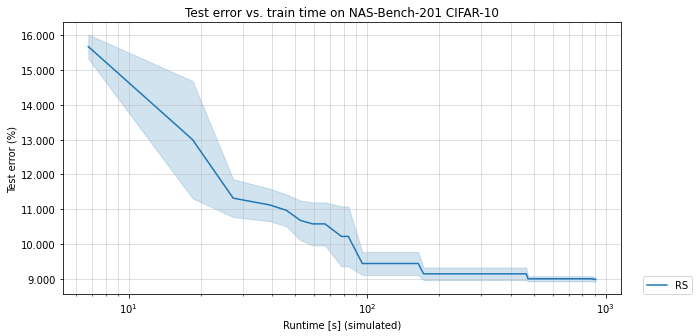

In [ ]:
# Plot RS for three seeds
plot_optimizers(trajectories, benchmark_title="NAS-Bench-201 CIFAR-10")

# TASK 2: Search using the Regularized Evolution Optimizer

In this task, you should:
1.   Search the NAS-Bench-201(CIFAR-10) space space using Regularized Evolution optimizer for 100 epochs
2.   Plot the search trajectory of the optimizer



## Regularized Evolution
Regularized Evolution starts with a population of randomly sampled architectures. In every epoch, it samples a random subset of architectures from this population and picks the best one. The selected architecture is then mutated and added to the population, while discarding the oldest architecture from it. Finally the best model from the ones seen so far is selected.

For a more formal description of the Regularized Evolution algorithm, see below:

![](https://drive.google.com/uc?id=11rF0ZQSoth4dMe8G5tmdemw2WBmXBerF)


In [ ]:
########## START TODO ############

# 1. Define the Regularized Evolution optimizer
# 2. Define the the NASBench201SearchSpace
# 3. Define the configuration and the appropriate dataset api
# These will be consumed by run_optimizer in the next few lines

optimizer_type = RegularizedEvolution
search_space_type = NasBench201SearchSpace # {NasBench101SearchSpace, NasBench201SearchSpace, NasBench301SearchSpace}

# Set the dataset
dataset = 'cifar10' # cifar10 for NB301, {cifar10, cifar100, ImageNet16-120} for NB201, cifar10 for NB101

# The configuration used by the Trainer and Optimizer
# The missing information will be populated inside run_optimizer
config_dict = {
    'search': {
        # Required by Trainer
        'epochs': 100, # Number of steps of the optimizer to run (in case of Random Search, for example, this is the number of models sampled)
        'checkpoint_freq': 200,

        # Required by Random Search optimizer
        'fidelity': -1,

        # Required by RegularizedEvolution
        'sample_size': 10,
        'population_size': 30,
    }
}
config = CfgNode(config_dict)


dataset_api = dataset_apis["NASBench201-cifar10"]

########## END TODO ##############
trajectories["RE"] = [] # initialize RE trajectories

for seed in [333, 444, 555]: #Run RE for 3 seeds
    search_trajectory, best_model, best_model_val_acc = run_optimizer(
                                                          optimizer_type=optimizer_type,
                                                          search_space_type=search_space_type,
                                                          dataset=dataset,
                                                          dataset_api=dataset_api,
                                                          config=config,
                                                          seed=seed
                                                        )
    trajectories["RE"].append(search_trajectory)

[10/11 15:03:56 naslib]: Configuration is 
dataset: cifar10
save: runs/RegularizedEvolution/NasBench201SearchSpace/cifar10/333
search:
  checkpoint_freq: 200
  epochs: 100
  fidelity: -1
  population_size: 30
  sample_size: 10
  seed: 333
[10/11 15:03:56 naslib]: Loading Benchmark API
[10/11 15:03:57 nl.defaults.trainer]: Beginning search
[10/11 15:03:57 nl.optimizers.discrete.re.optimizer]: Start sampling architectures to fill the population
[10/11 15:03:57 nl.optimizers.discrete.re.optimizer]: Population size 1
[10/11 15:03:57 nl.defaults.trainer]: Epoch 0 done. Train accuracy: 99.54800, Validation accuracy: 83.83000
[10/11 15:03:57 nl.optimizers.discrete.re.optimizer]: Start sampling architectures to fill the population
[10/11 15:03:57 nl.defaults.trainer]: Epoch 1 done. Train accuracy: 72.61200, Validation accuracy: 66.22000
[10/11 15:03:57 nl.optimizers.discrete.re.optimizer]: Start sampling architectures to fill the population
[10/11 15:03:57 nl.defaults.trainer]: Epoch 2 done. T

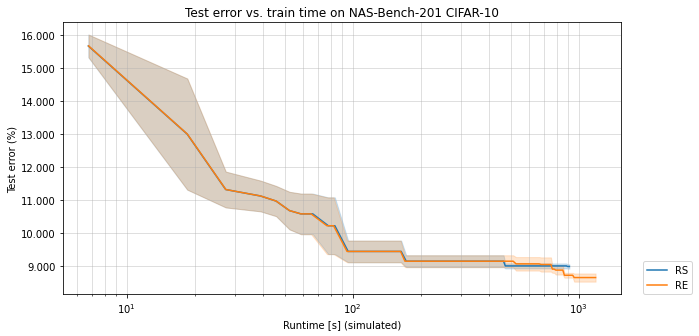

In [ ]:
# Plot RS and RE on the same plot for 3
plot_optimizers(trajectories, benchmark_title="NAS-Bench-201 CIFAR-10")

# You might notice that both RS and RE optimizers have the same performance in the beginning
# This is because RE starts by sampling random models, and since we fixed the seed for the random number generator (for reproducibility),
# these are the same models sampled by the RS optimizer.


### BANANAS
Bayesian Optimization with Neural Architectures for Neural Architecture Search (BANANAS) starts by randomly sampling and evaluating architectures. This is followed by training an ensemble of predictors using the architecture's encoding. Next a set of top performing architectures are randomly mutated to generate new architecture candidates. The architecture amongst these candidates with the lowest value of the aquisition funtion is then added to the set of models used to fit the predictor in the next epoch.

 You can find the formal description of the BANANAS algorithm below:
![](https://drive.google.com/uc?id=1KelEs9KUXpyO1MiO_jJ4b7gQSMWgJBlz)

In [ ]:
# Now let's use BANANAS as a search optimizer with xgb as its predictor
# Note: We are fitting a predictor every config.search.k epochs so this is expected to be slower than RE and RS
optimizer_type = Bananas # {RegularizedEvolution, RandomSearch}
search_space_type = NasBench201SearchSpace # {NasBench101SearchSpace, NasBench201SearchSpace, NasBench301SearchSpace}

# Set the dataset
dataset = 'cifar10' # cifar10 for NB101 and NB301, {cifar100, ImageNet16-120} for NB201

# define the predictor
predictor = 'xgb'
config_dict = {
    'search': {
        # Required by Trainer
        'epochs': 100,
        'checkpoint_freq': 100,

        # Required by Random Search optimizer
        'fidelity': -1,

        # Required by RegularizedEvolution
        'population_size': 30, # Number of models to sample in the beginning
        'sample_size': 10, # Number of candidates to sample from the population, to select the next parent

        # Required by BANANAS
        "num_init": 10, # Number of models to randomly sample in the beginning
        "num_ensemble": 1, # Number of predictors to ensemble
        "predictor_type": predictor, # The type of predictor to use
        "acq_fn_type": "its", # Thompson Sampling
        "acq_fn_optimization": 'random_sampling',
        "num_candidates": 100, # Number of candidates to sample
        'k': 20, # Top k candidates are chosen for evaluation
        "encoding_type": 'path', # Type of encoding to use while
        "num_arches_to_mutate":5, # Not used when acq_fn_optimization is random_sampling
        "max_mutations":1, # Not used when acq_fn_optimization is random_sampling
     }
   }

config = CfgNode(config_dict)

dataset_api = dataset_apis["NASBench201-cifar10"]

for seed in [333, 444, 555]: # Run BANANAS with XGB for 3 seeds
    search_trajectory, best_model, best_model_val_acc = run_optimizer(
                                                          optimizer_type,
                                                          search_space_type,
                                                          dataset,
                                                          dataset_api,
                                                          config,
                                                          seed
                                                        )
    experiment_name = "BANANAS_"+str(config.search.predictor_type)

    if experiment_name not in trajectories.keys():
       trajectories[experiment_name] = []

    trajectories[experiment_name].append(search_trajectory)

[10/11 15:06:33 naslib]: Configuration is 
dataset: cifar10
save: runs/Bananas/NasBench201SearchSpace/cifar10/333
search:
  acq_fn_optimization: random_sampling
  acq_fn_type: its
  checkpoint_freq: 100
  encoding_type: path
  epochs: 100
  fidelity: -1
  k: 20
  max_mutations: 1
  num_arches_to_mutate: 5
  num_candidates: 100
  num_ensemble: 1
  num_init: 10
  population_size: 30
  predictor_type: xgb
  sample_size: 10
  seed: 333
[10/11 15:06:33 naslib]: Loading Benchmark API
[10/11 15:06:34 nl.defaults.trainer]: Beginning search
[10/11 15:06:34 nl.defaults.trainer]: Epoch 0 done. Train accuracy: 99.54800, Validation accuracy: 83.83000
[10/11 15:06:34 nl.defaults.trainer]: Epoch 1 done. Train accuracy: 72.61200, Validation accuracy: 66.22000
[10/11 15:06:34 nl.defaults.trainer]: Epoch 2 done. Train accuracy: 99.91200, Validation accuracy: 88.09000
[10/11 15:06:34 nl.defaults.trainer]: Epoch 3 done. Train accuracy: 99.88400, Validation accuracy: 88.68000
[10/11 15:06:34 nl.defaults.tr

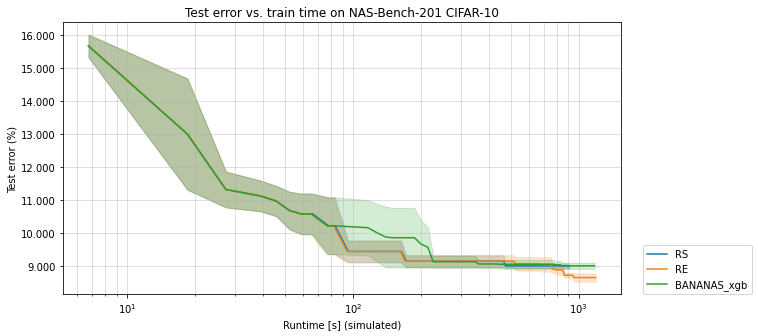

In [ ]:
# Plot Bananas (xgb predictor), RS and RE on the same plot for 3 seeds
plot_optimizers(trajectories, benchmark_title="NAS-Bench-201 CIFAR-10")

# TASK 3: BANANAS with predictor of your choice

In this task you will use BANANAS with a predictor of your choice.


NASLib supports a variety of predictors which could be used with BANANAS, some of which are:
1.   [xgb](https://xgboost.readthedocs.io/en/stable/) - XGBoost
2.   [lgb](https://lightgbm.readthedocs.io/en/v3.3.2/) - LightGBM
3.   [mlp](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) - Multi Layer Perceptron
4.   [rf](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) - Random Forest
5.   [gp](https://pyro.ai/examples/gp.html) - Gausian Process
6.   [bayes_lin_reg](https://num.pyro.ai/en/stable/examples/bnn.html) - Bayesian Linear Regression



In [ ]:
########## START TODO ############

# 1. Define the BANANAS optimizer
# 2. Choose any predictor from amongst ['mlp','lgb', 'rf','bayes_lin_reg','gp']
# 3. Define the NAS-Bench-201 Search Space (CIFAR-10)
# 4. Define the config and the appropriate dataset api

optimizer_type = Bananas # {RegularizedEvolution, RandomSearch}
search_space_type = NasBench201SearchSpace # {NasBench101SearchSpace, NasBench201SearchSpace, NasBench301SearchSpace}

# Set the dataset
dataset = 'cifar10' # cifar10 for NB101 and NB301, {cifar100, ImageNet16-120} for NB201

# define the predictor
predictor = 'gp'
config_dict = {
    'search': {
        # Required by Trainer
        'epochs': 100,
        'checkpoint_freq': 100,



        # Required by BANANAS
        "num_init": 10, # Number of models to randomly sample in the beginning
        "num_ensemble": 1, # Number of predictors to ensemble
        "predictor_type": predictor, # The type of predictor to use
        "acq_fn_type": "its", # Thompson Sampling
        "acq_fn_optimization": 'random_sampling',
        "num_candidates": 100, # Number of candidates to sample
        'k': 20, # Top k candidates are chosen for evaluation
        "encoding_type": 'path', # Type of encoding to use while
        "num_arches_to_mutate":5, # Not used when acq_fn_optimization is random_sampling
        "max_mutations":1, # Not used when acq_fn_optimization is random_sampling
     }
   }

config = CfgNode(config_dict)

dataset_api = dataset_apis["NASBench201-cifar10"]


########## END TODO ############
for seed in [333, 444, 555]: # Run BANANAS for 3 seeds with a predictor of your choice
    search_trajectory, best_model, best_model_val_acc = run_optimizer(
                                                          optimizer_type=optimizer_type,
                                                          search_space_type=search_space_type,
                                                          dataset=dataset,
                                                          dataset_api=dataset_api,
                                                          config=config,
                                                          seed=seed
                                                      )
    experiment_name = "BANANAS_"+str(predictor)

    if experiment_name not in trajectories.keys():
       trajectories[experiment_name] = []

    trajectories[experiment_name].append(search_trajectory)

[10/11 15:16:00 naslib]: Configuration is 
dataset: cifar10
save: runs/Bananas/NasBench201SearchSpace/cifar10/333
search:
  acq_fn_optimization: random_sampling
  acq_fn_type: its
  checkpoint_freq: 100
  encoding_type: path
  epochs: 100
  k: 20
  max_mutations: 1
  num_arches_to_mutate: 5
  num_candidates: 100
  num_ensemble: 1
  num_init: 10
  predictor_type: gp
  seed: 333
[10/11 15:16:01 naslib]: Loading Benchmark API
[10/11 15:16:01 nl.defaults.trainer]: Beginning search
[10/11 15:16:01 nl.defaults.trainer]: Epoch 0 done. Train accuracy: 99.54800, Validation accuracy: 83.83000
[10/11 15:16:01 nl.defaults.trainer]: Epoch 1 done. Train accuracy: 72.61200, Validation accuracy: 66.22000
[10/11 15:16:01 nl.defaults.trainer]: Epoch 2 done. Train accuracy: 99.91200, Validation accuracy: 88.09000
[10/11 15:16:01 nl.defaults.trainer]: Epoch 3 done. Train accuracy: 99.88400, Validation accuracy: 88.68000
[10/11 15:16:01 nl.defaults.trainer]: Epoch 4 done. Train accuracy: 99.92000, Validati

/usr/local/lib/python3.7/dist-packages/pyro/contrib/gp/models/gpr.py:81: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1744.)
  Lff = Kff.cholesky()


Finished tuning GP hyperparameters


/usr/local/lib/python3.7/dist-packages/pyro/contrib/gp/util.py:109: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  Lffinv_pack = pack.triangular_solve(Lff, upper=False)[0]


[10/11 15:16:26 nl.defaults.trainer]: Epoch 10 done. Train accuracy: 99.94800, Validation accuracy: 89.86000
[10/11 15:16:26 nl.defaults.trainer]: Epoch 11 done. Train accuracy: 99.98800, Validation accuracy: 90.56000
[10/11 15:16:26 nl.defaults.trainer]: Epoch 12 done. Train accuracy: 99.98400, Validation accuracy: 90.95000
[10/11 15:16:26 nl.defaults.trainer]: Epoch 13 done. Train accuracy: 99.97200, Validation accuracy: 90.10000
[10/11 15:16:26 nl.defaults.trainer]: Epoch 14 done. Train accuracy: 92.82800, Validation accuracy: 79.55000
[10/11 15:16:26 nl.defaults.trainer]: Epoch 15 done. Train accuracy: 98.34400, Validation accuracy: 84.97000
[10/11 15:16:26 nl.defaults.trainer]: Epoch 16 done. Train accuracy: 98.07200, Validation accuracy: 84.94000
[10/11 15:16:26 nl.defaults.trainer]: Epoch 17 done. Train accuracy: 99.26800, Validation accuracy: 86.98000
[10/11 15:16:26 nl.defaults.trainer]: Epoch 18 done. Train accuracy: 99.96400, Validation accuracy: 88.91000
[10/11 15:16:26 nl.

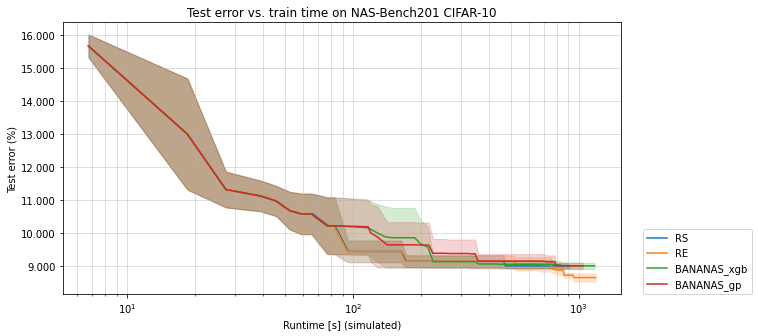

In [ ]:
# Plot Bananas (predictor of your choice), Bananas (xgb predictor), RS and RE on the same plot for 3 seeds
plot_optimizers(trajectories, benchmark_title='NAS-Bench201 CIFAR-10')

<a name="zcps"></a>
# 4. Zero Cost Proxies

Zero Cost proxies allow us to *rank* models using only a single forward and backward pass of a minibatch of data. Since they require much less time and compute to score models (as opposed to training them from scratch and comparing them, for example), they can be used as a cheap *proxy* to speed up black-box optimizers.

In this section, we look how we can use the 13 Zero Cost proxies available in NASLib ( Table 1, [NAS-Bench-Suite-Zero:
Accelerating Research on Zero Cost Proxies](https://arxiv.org/pdf/2210.03230.pdf)) to *score* a model. Intuitively, the higher the score of a model, the better we expect the model to perform (this isn't always true, though - there are cases where the scores are anti-correlated with the validation performance).

A perfect Zero Cost proxy would be one where its scores for models are perfectly correlated with the performance of those models, i.e., the ranking of the models by the Zero Cost proxies are the same as their ranking after they have been fully trained and evaluated.

Let’s now see how to use Zero Cost proxies in NASLib

In [ ]:
# Imports used throughout this section
from naslib.predictors import ZeroCost
from naslib.search_spaces import NasBench201SearchSpace
from naslib.utils import get_train_val_loaders, get_project_root
from fvcore.common.config import CfgNode
from tqdm import tqdm

In [ ]:
# Create configs required for get_train_val_loaders
config_dict = {
    'dataset': 'cifar10', # Dataset to loader: can be cifar10, cifar100, ImageNet16-120
    'data': str(get_project_root()) + '/data', # path to naslib/data
    'search': {
        'seed': 9001, # Seed to use in the train, validation and test dataloaders
        'train_portion': 0.7, # Portion of train dataset to use as train dataset. The rest is used as validation dataset.
        'batch_size': 32, # batch size of the dataloaders
    }
}
config = CfgNode(config_dict)

# Get the dataloaders
train_loader, val_loader, test_loader, train_transform, valid_transform = get_train_val_loaders(config)

# Sample a random NB201 graph and instantiate it
graph = NasBench201SearchSpace()
graph.sample_random_architecture()
graph.parse()

# Instantiate the ZeroCost predictor
# The Zero Cost predictors can be any of the following:
# {'epe_nas', 'fisher', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'plain', 'snip', 'synflow', 'zen', 'flops', 'params'}

zc_proxy = 'plain'
zc_predictor = ZeroCost(method_type=zc_proxy)
score = zc_predictor.query(graph=graph, dataloader=train_loader)

print(f'Score of model for Zero Cost predictor {zc_proxy}: {score}')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/NASLib/naslib/data/cifar-10-python.tar.gz to /content/NASLib/naslib/data
Files already downloaded and verified
Score of model for Zero Cost predictor plain: 0.15324528515338898


Let's now try scoring the same model with all the Zero Cost proxies. Remember that it only makes sense to make comparisons between the scores of different models of a given proxy.

In [ ]:
# Instantiate the ZeroCost predictor
# The Zero Cost predictors can be any of the following:
zc_proxies = ['epe_nas', 'fisher', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'plain', 'snip', 'synflow', 'zen', 'flops', 'params']

print('Scores of the model')
for zc_proxy in zc_proxies:
    zc_predictor = ZeroCost(method_type=zc_proxy)
    score = zc_predictor.query(graph=graph, dataloader=train_loader)
    print(f'{zc_proxy}: {score:3f}')

Scores of the model
epe_nas: 122.201753


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


fisher: 0.017888
grad_norm: 4.805425
grasp: -0.079522
jacov: -982.109134
l2_norm: 78.618675
nwot: 310.059601
plain: 0.267241
snip: 7.487453
synflow: 25.170673
zen: 24.777748
flops: 14.886592
params: 0.101306


# Task 4a: Intro to Zero Cost Proxies

Now that we have seen all the Zero Cost proxies in action, let's compute the *rank correlation* between the proxy scores of a few models and their validation performance. The higher the correlation, the better the proxy.

In [ ]:
# Required imports
from naslib.search_spaces.core import Metric
from naslib.utils import compute_scores
from naslib.utils import get_train_val_loaders

In [ ]:
# Sample 50 random architectures, query their performances
n_graphs = 50
models = []
val_accs = []
zc_scores = []

print('Loading NAS-Bench-201 API...')
api = dataset_apis['NASBench201-cifar10']

print(f'Sampling {n_graphs} NAS-Bench-201 models...')
for _ in tqdm(range(n_graphs)):
    graph = NasBench201SearchSpace()
    graph.sample_random_architecture()
    graph.parse()

    models.append(graph)

print('Querying validation performance for all models')
for graph in tqdm(models):
    acc = graph.query(metric=Metric.VAL_ACCURACY, dataset='cifar10', dataset_api=api)
    val_accs.append(acc)

def score_models_with_zc_predictor(models, zc_predictor):
    """
      Scores the models with the given ZeroCost predictor

      Args:
        models        : List of models
        zc_predictor  : Instance of ZeroCost

      return:
        List of scores of the given models
    """
    scores = []
    ######### START TODO ############

    # Score the models
    # Add the scores to the list named scores

    for model in models:
      score = zc_predictor.query(graph=model, dataloader=train_loader)
      scores.append(score)



    ########## END TODO #############

    return scores

print('Scoring the models using Zero Cost predictor (jacov)')
zc_predictor = ZeroCost(method_type='jacov')
zc_scores = score_models_with_zc_predictor(models, zc_predictor)

# We now compute the correlation between val_accs (ground truth) and zc_scores (proxy scores)
correlations = compute_scores(ytest=val_accs, test_pred=zc_scores)

# Extract the results
kendalltau_corr = correlations['kendalltau']
spearman_corr = correlations['spearman']
pearson_corr = correlations['pearson']

print('*'*50)
print('Validation accuracies: ', val_accs)
print()
print('Zero Cost predictor scores: ', zc_scores)
print('*'*50)
print('Correlations between validation accuracies (ground truth) and Zero Cost predictor scores (prediction): ')
print('Kendall Tau correlation:', kendalltau_corr)
print('Spearman correlation:', spearman_corr)
print('Pearson correlation:', pearson_corr)

  2%|▏         | 1/50 [00:00<00:08,  6.03it/s]

Loading NAS-Bench-201 API...
Sampling 50 NAS-Bench-201 models...


100%|██████████| 50/50 [00:00<00:00, 4908.95it/s]


Querying validation performance for all models
Scoring the models using Zero Cost predictor (jacov)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Array must not contain infs or NaNs
**************************************************
Validation accuracies:  [85.69, 86.8, 87.95, 85.07, 83.39, 88.75, 89.02, 91.09, 77.74, 85.5, 80.67, 88.31, 89.15, 82.22, 88.22, 84.54, 82.3, 88.7, 88.64, 87.32, 83.78, 83.55, 89.1, 88.19, 79.17, 84.13, 86.95, 84.97, 90.19, 77.14, 71.25, 79.65, 58.86, 87.15, 88.75, 89.12, 74.49, 88.22, 86.04, 83.62, 84.65, 83.92, 70.9, 10.0, 89.39, 90.4, 89.44, 85.53, 89.19, 88.6]

Zero Cost predictor scores:  [-33.639511217158244, -38.66234568740176, -32.49135617379887, -32.85971430540948, -37.72166642757663, -32.286922699399284, -32.314596369741096, -32.263534944003695, -1076.0893883284084, -54.6475491733747, -89.32119942523258, -32.28917423679049, -32.28866724180655, -68.01020102632505, -32.38961562704644, -109.46975719845918, -58.20351592359688, -33.709746357268415, -32.27346531178861, -35.23932703620541, -32.33196568417813, -43.29776389040832, -32.268270859893725, -32.339262013902456, -47.051053274730265, -32.311

## Zero Cost Proxy Benchmarks

Much like NAS-Benchmark APIs, we have also introduced Zero Cost Benchmark APIs in order to speed-up NAS research even further. The Zero Cost Benchmark API lets you instantly query the Zero Cost proxy scores for a given model and search space. For example, if your black-box optimizer uses Zero Cost proxies, you could leverage the Zero Cost Benchmarks to run the experiments much faster by simply querying them for the scores instead of explicitly calling the Zero Cost Predictor.

We have already downloaded the Zero Cost Benchmark API for NAS-Bench-201, which has the scores for all 15625 models evaluated for all three datasets (CIFAR-10, CIFAR-100 and ImageNet16-120) using all 13 Zero Cost proxies.


Let's now query the benchmark API

In [ ]:
from naslib.utils import get_zc_benchmark_api

# Load the Zero Cost Benchmark API for NAS-Bench-201 CIFAR-10
zc_api = get_zc_benchmark_api('nasbench201', 'cifar10')
graph = models[0]

# Use the Zero Cost Benchmark to get the score for the model for a particular ZC proxy
pred = 'grasp'
spec = graph.get_hash()

# The Zero Cost Benchmarks are simply dictionaries, and the key used to query a model
# is sim the stringified NASLib representation of that model
score = zc_api[str(spec)][pred]['score']
time_to_compute = zc_api[str(spec)][pred]['time']

print(f'All the data available in the Zero Cost benchmark for model {spec}: ')
print(zc_api[str(spec)][pred])
print(f'Score of model with spec {spec} for Zero Cost proxies {pred}: {score}')
print(f'Time taken to compute the score for the model: {time_to_compute:.2f}s')

# Task 4b: Rank Correlation of Zero Cost Proxies

In this task, we shall query the ZCP Benchmark for the scores of all the proxies for 100 models randomly sampled from the NB201-CIFAR10 search space. We then compute the rank correlation for each of these proxies. Your task is to find the best proxy for the NB201-CIFAR10 (i.e., the Zero Cost proxy with the best rank correlation)

In [ ]:
# List of all Zero Cost predictors
zc_proxies = ['epe_nas', 'fisher', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'plain', 'snip', 'synflow', 'zen', 'flops', 'params']
zc_scores = {proxy: [] for proxy in zc_proxies} # Just dictionary of an empty list for each predictor
print('zc_scores:', zc_scores)

models = []

# Sample 100 models

print(f'Sampling 100 NAS-Bench-201 models...')
n_graphs = 100
np.random.seed(9001) # setting the seed so the same models are sampled every time this cell is run
for _ in tqdm(range(n_graphs)):
    graph = NasBench201SearchSpace()
    graph.sample_random_architecture()
    graph.parse()

    models.append(graph)

val_accs = []
kt_corrs = []

########## START TODO ############

# 1. Query the scores of all Zero Cost proxies for all the models
# 2. Query the Validation accuracies of all models
# 3. Compute the Kendall-Tau rank correlations between them for each of the proxies
# 4. Finally, save your results to kt_corrs as tuples as follows:
#    kt_corrs = [(proxy1_name, correlation), (proxy2_name, correlation) ... (proxy13_name, correlation)]


########### END TODO #############

# Sorting the models from highest
kt_corrs = sorted(kt_corrs, reverse=True, key=lambda pred_score_tuple: pred_score_tuple[1])

  print('ZC predictors ranked (best to worst):')
for idx, (pred, score) in enumerate(kt_corrs):
    print(f'#{idx+1}', pred, score)

# Bonus Challenge: Awesome Optimizer

Blazed through the tutorial? Want an extra challenge?

We ask you to write a black box optimizer that beats the RandomSearch baseline for NAS-Bench-201 for CIFAR-10.

Given below is the skeletal code for a NASLib Black-box optimizer, with everything except its main method - new_epoch() - filled. This method is called in every step of the search of the Trainer (as seen in the run_optimizer function before) and is responsible for executing the main logic of the optimizer. E.g., the Random-Search optimizer samples a random architecture and queries its validation performance here.

Remember that every query of a NAS-Benchmark for its validation performance is a substitute for training the model from scratch and evaluating its performance.

In this challenge, there is only one rule: **You may query the validation performance of only ONE model in new_epoch()**.

i.e., only one model shall be evaluated in every call of new_epoch(). Feel free to sample several models, and rank them, and query only the best model, for example. You are free to implement your own ideas here.
  

In [ ]:
import torch

from fvcore.common.config import CfgNode

from naslib.optimizers.core.metaclasses import MetaOptimizer
from naslib.predictors.zerocost import ZeroCost
from naslib.search_spaces.core.graph import Graph
from naslib.search_spaces.core.query_metrics import Metric
from naslib.utils import get_train_val_loaders

# Import whatever else you want from NASLib

class AwesomeOptimizer(MetaOptimizer):
    """
    Implement your awesome optimizer here.

    This optimizer inherits from RandomSearch purely for convenience. Your search
    method does not have to be random at all. Feel free to write your own logic, and add
    any new methods that you need for it.
    """

    def __init__(self, config: CfgNode):
        """
        Initialize your optimizer

        Args:
            config
        """
        super(AwesomeOptimizer, self).__init__()
        # These two lists are required
        self.sampled_archs = []
        self.history = []

        self.performance_metric = Metric.VAL_ACCURACY
        # You can add more properties to the config file and read them if you want
        self.dataset = config.dataset
        self.fidelity = config.search.fidelity

        # A few things that might be useful to you. Add/remove code as you wish.
        self.trainloader = get_train_val_loaders(config)[0]
        self.zerocostpredictor = ZeroCost(method_type='l2_norm')
        # self.my_awesome_property = config.my_awesome_property

        ###########################################################
        ##################### START TODO ##########################


        # Need more stuff in your initializer? Write them here!


        ##################### END TODO  ##########################
        ##########################################################


    def adapt_search_space(self, search_space: Graph, scope: str = None, dataset_api: dict = None):
        """
        This method has to be called with the search_space and the nas benchmark api before the optimizer
        can be used.

        Args:
            search_space : An instance of the search space, such as NasBench201SearchSpace()
            scope        : Relevant only for one-shot optimizers
            dataset_api  : NAS Benchmark API for the given search space
        """
        self.search_space = search_space.clone()
        self.dataset_api = dataset_api


    def new_epoch(self, epoch: int):
        """
        This method is called in every "step" of the search.

        Args:
            epoch: epoch number
        """

        # For reference, this is the code inside new_epoch in RandomSearch:

        # model = torch.nn.Module()
        # model.arch = self.search_space.clone()
        # model.arch.sample_random_architecture(dataset_api=self.dataset_api)
        # model.accuracy = model.arch.query(
        #     self.performance_metric,
        #     self.dataset,
        #     epoch=self.fidelity,
        #     dataset_api=self.dataset_api,
        # )
        # self.sampled_archs.append(model)
        # self._update_history(model)

        # All the code above does is sample a random architecture and query the
        # benchmark for its validation performance

        ###########################################################
        ##################### START TODO ##########################


        # Write your logic here
        # Also feel free to write new methods in this class


        ##################### END TODO  ##########################
        ##########################################################

        self.sampled_archs.append(model) # This line is required. Add your chosen model to sampled_archs here.

    def get_final_architecture(self):
        """
        Returns the sampled architecture with the lowest validation error.
        """
        return max(self.sampled_archs, key=lambda x: x.accuracy).arch

    def train_statistics(self, report_incumbent: bool = True):

        if report_incumbent:
            best_arch = self.get_final_architecture()
        else:
            best_arch = self.sampled_archs[-1].arch

        return (
            best_arch.query(
                Metric.TRAIN_ACCURACY, self.dataset, dataset_api=self.dataset_api
            ),
            best_arch.query(
                Metric.VAL_ACCURACY, self.dataset, dataset_api=self.dataset_api
            ),
            best_arch.query(
                Metric.TEST_ACCURACY, self.dataset, dataset_api=self.dataset_api
            ),
            best_arch.query(
                Metric.TRAIN_TIME, self.dataset, dataset_api=self.dataset_api
            ),
        )

    def test_statistics(self):
        best_arch = self.get_final_architecture()
        return best_arch.query(Metric.RAW, self.dataset, dataset_api=self.dataset_api)

    def _update_history(self, child):
        """
            We want to maintain only the history of the 100 best models in self.history
            (self.sampled_archs stores the list of all models sampled.)
        """
        if len(self.history) < 100:
            self.history.append(child)
        else:
            for i, p in enumerate(self.history):
                if child.accuracy > p.accuracy:
                    self.history[i] = child
                    break

    def get_checkpointables(self):
        return {"models": self.history}

    def get_op_optimizer():
        raise NotImplementedError()


In [ ]:
########## START TODO ############

# 1. Run the RS optimizer on NAS-Bench-201
# 2. Run AwesomeOptimizer on NAS-Bench-201
# 3. Plot the results for both the optimizers

########## END TODO ############